This notebook contains some explorations in implementing Monte Carlo methods for option pricing. So far I have tested an implementation of the Longstaff-Schwartz method with antithetic variates for pricing an American put on a single asset. It is a work in progress and sections (WIP) are outlines that may be skipped for now. Future additions will include the multi-asset American put, alternative regression methods for Longstaff-Schwartz, Euler v. Milstein discretization schemes, a comparison of different univariate transformations, and implementation of different pseudo- and quasi-random sequences (e.g. the Sobol sequence). 

$$Introduction$$

Monte Carlo simulation is one of the most widely-used numerical methods in the pricing of deriviative securities (and in other fields as well). The idea behind its application in finance it is very intuitive. We have some derivative security, say a call option on a stock, whose value depends in some way on the future evolution of the price of the underlying asset, the stock in this case. In Monte Carlo, we simulate many such paths (which follow a goemetric Brownian motion), calculate the discounted payoff of the option in each path, and then take the average of these discounted payoffs over all such paths. 

A bit more formally, suppose we have a derivative security whose payoff, f(S), is a function of the underlying asset, S. Then the fair value of the derivative security is given by 

$$ { \int_{0}^{T} e^{-rT} f(X) \,dx } $$

where the lifetime of the derivative security is given by \[0, T\] and the exponential denotes the continuosly compounded discount rate of rate r. We can estimate the value of this integral by Monte Carlo integration. 

We are concerned with the theory of Monte Carlo pricing only insofar as it helps us with our real concern in this notebook, the practical implementation of Monte Carlo pricing in Python. We can break up the implementation into five different modules, each of which has a large literature covering them. 

(1) Random number generation (or low-discrepancy sequence generation)

(2) Transformation of univariate draws into normal draws

(3) Construction of asset price paths using normal draws

(4) Calculating the value of an option given a particular asset price path

(5) Variance reduction

Essentially, we need to generate a sequence of random draws from a uniform distribution on the unit interval (\[0,1)); transform this uniform draws into samples from a standard normal distribution; use the standard normal samples to construct paths of geometric Brownian motion; obtain the option value from each path (e.g. discounting the terminal payoff in the case of a European option); and finally apply some variance reduction techniques (e.g. antithetic variates or control variates) at various points in the previous steps to create tighter confidence intervals and possibly reduce computation time. 

We will go over each step in further detail as we implement it, but the above is the big picture of implementation. 



$$ Random \ number \ generation \ (WIP)$$

In theory, we draw random samples from the standard normal distribution and go on our way in simulating stock price paths. In practice, we need to first draw random numbers. We can only do this with deterministic functions on our computers. Much can be said about this, but we can be reasonbly content for now with the knowledge that computer scientists and mathematicians have come up with several deterministic methods of generating "pseudo-random numbers" which have some clever ways of obtaining an initial input for the function and which might pass several statistical tests of randomness. 


$$ Low-discrepancy \ sequences \ (WIP) $$

At some point we might wonder whether we need a way to generate truly random numbers for the purposes of Monte Carlo simulation. Consider again the case of Monte Carlo integration, or more specifically the case of finding the area of some shape. We are interested in simulation because the idea is that simulation points will eventually cover all areas of the shape. But if we consider some of the best pseudo-random number generation methods, often times there are both sizable gaps (in which there are no sample points) and large clumps (in which there are too many) of points that will distort our measurement of the area. What if we simply constructed a sequence that "evenly" covered the desired area?

(Insert pseudo-rng samples of a 2d hypercube)

This is the idea behind low-discrepancy sequences. Informally, the discrepancy of a sequence of numbers can be thought of the size of the largest gap over all sub-regions of the region being investigated. We construct a sequence which has low discrepancy. Consider the Sobol sequence and its coverage of the 2d hypercube (also called a "square"). 

(Insert Sobol sequence in 2d hypercube)

There are a variety of low-discrepancy sequences that we can use and some even have implementations in widely-used packages like scipy. We consider here the Sobol, Halton, and Niederreiter sequences. 

(Considerations in using low-discrepancy sequences; they can be used poorly and in fact we will show implementation that intentionally ignores these warnings in order to show the potential problems that come with the misuse of low-discrepancy sequences)

$$ Univariate \ Transformations \ (WIP) $$




$$ Path \ construction \  $$

We construct discrete-time paths of geometric Brownian motion (GBM) using Black-Scholes risk-neutral dynamics. We divide the interval \[0,T\] into N subdivisions, and for each i = 1,...,N:

$$ S_i = S_{i-1} exp\{(r - \frac{1}{2}\sigma^2) \Delta t + exp\{\sigma \sqrt{\Delta t} Z\}\}, $$

where Z is a sample from the standard normal distribution (this is called Euler discretization). The initial value S(0) is an input to our model. Below is a Python function for generating a simulated path. We then check the sample distribution of the log returns for a particular example. The returns of GBM should be lognormally distributed, and therefore the *log* returns should be normally distributed. We compare the histogram of log returns with a normal curve to check that our path construction is on the right track. 

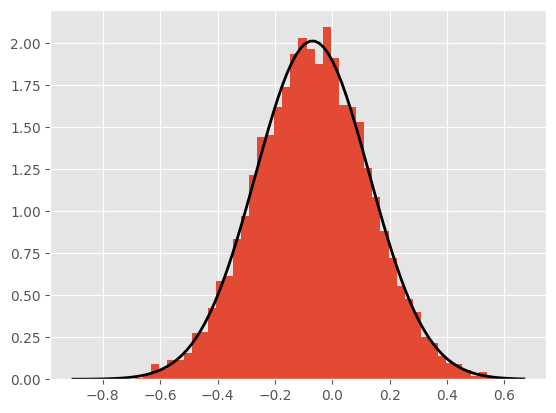

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib import style
style.use('ggplot')

def sim_path(S0, r, sigma, div, rng, T, N):
    dt = T / N
    S = np.zeros(N)
    drift = np.exp((r - div - 0.5 * np.power(sigma,2)) * dt)
    S[0] = S0 

    for i in range(1, N):
        Z = rng.normal(0,1)
        S[i] = S[i - 1] * drift * np.exp(sigma * np.sqrt(dt) * Z)
        S_anti[i] = S_anti[i - 1] * drift /  np.exp(sigma * np.sqrt(dt) * Z)

    return S

N = 100
M = 10000
S0 = 100
r = 0.05
sigma = 0.2
T = 1
div = 0.1

S = np.empty([M, N + 1])
S_anti = np.empty([M, N + 1])
for i in range(M):
    S[i] = sim_path(S0, r, sigma, div, np.random.default_rng(), T, N+1)

log_returns = np.log(S[:, -1] / S0)
plt.hist(log_returns, bins=50, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(log_returns), np.std(log_returns))

plt.plot(x, p, 'k', linewidth=2)
plt.show()

$$ Calculating \ Option \ Prices $$

Given a method for generating random/low-discrepancy sequences, transforming them into standard normal draws, constructing asset price paths with these draws, we still have some freedom with respect to calculating the value of the derivative security from the simulated paths. Our method here is dependent on the derivative security of interest. For example, if we have a European call option, we simply look at the last element in each row our of simulation matrix and input it into the payoff function for a European call:

$$ \forall i \in 1, ... M, max\{S_{i,T} - K, 0\}$$

Then we discount these payoffs using the continously compounded interest rate and average the discounted payoffs over all simulated paths to get our estimated option value. 


In [8]:
import numpy as np
from scipy import stats


def mc_pricer_euro_put(S0, K, r, sigma, div, T, N, M):
    """Monte Carlo simulation to estimate the price of a European put option."""
    # Simulate M stock price paths
    dt = T / N
    paths = np.empty([M, N + 1])
    for i in range(M):
        paths[i] = sim_path(S0, r, sigma, div, np.random.default_rng(), T, N+1)
    
    V = np.exp(-r * T) * np.maximum(K - paths[:, -1], 0)
    
    # return average
    V_final = np.mean(V)
    
    CI_bounds = 1.96 * (np.std(V) / np.sqrt(M)) 
    print(f"[{V_final - CI_bounds}, {V_final + CI_bounds}]")
    return V_final

def bsm_analytic_pricer_put(S0, K, r, sigma, T):
    """Calculates the Black-Scholes-Merton analytic price of a European put option."""
    d1 = (np.log(S0 / K) + (r + (np.power(sigma,2)/2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    P = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S0 * stats.norm.cdf(-d1)
    return P

bsm_price = bsm_analytic_pricer_put(100, 100, 0.05, 0.2, 1)
mc_price = mc_pricer_euro_put(100, 100, 0.05, 0.2, 0, 1, 50, 20000)

print(f"Monte Carlo estimate: ${mc_price}")
print(f"BSM analytic price: ${bsm_price}")

[5.303735079537193, 5.538773835486524]
Monte Carlo estimate: $5.421254457511859
BSM analytic price: $5.573526022256971


For more sophisticated derivative securities, the methods can become quite involved. In this notebook, we are interested in pricing the American put option. The early-exercise feature of American options pose a particular challenge to Monte Carlo simulation and we are usually better off with a binomial tree, which handles early-exercise features with ease. But Monte Carlo is very useful for "higher-dimensional" derivative securities, such as Bermudan swaptions or American basket options, which also have early-exercise features. If we can somehow modify our Monte Carlo methods to deal with early-exercise features, then we can make use of this powerful method in pricing higher-dimensional American/Bermudan derivative securities. 

There are several different approaches in the literature on Monte Carlo pricing of derivative securities with early-exercise features. Here we consider the popular Longstaff-Schwartz method. For any method we need a way to deal with the fact that any time the holder of an American option may exercise it. We consider the discrete case (otherwise known as a Bermudan option) with the understanding that this will approximate the continuous case in the limit. 

For each time step n before the final time step N, we must have a way of comparing the conditional expectation of continuing to hold the option (hereafter known as the conditional expectation of continuation) with the payoff from immediately exercising the option. The simplest way of estimating the conditional expectation of continuation (conditional on the value of the stock price) is to look ahead one step in the future and discount the continuation value at that point back one time-step. For N - 1, this means discounting the terminal payoff one time-step. We are able to "peak into the future" because we are dealing with already-simulated asset price paths. 

The problem is that we will overfit to the data (the simulated paths). The result will be a highly biased estimate of the option price. Longstaff and Schwartz instead recommended that the conditional expectation be estimated through regression. For each time point n before terminal payoff, we consider the continuation values at the in-the-money paths (we could consider all paths and indeed we will include a function that does so). Regress these continuation values against the associated asset price to get some regression function. Then for each in-the-money path, compare the predicted value according to the regression with the payoff from immediate exercise. If the predicted value is larger, then we do not exercise. If the payoff from immediate exercise is larger, then set the continuation value equal to it and then discount it back one time-step. Repeat until finished then discount all continuation values back to 0 accordingly. Average the resulting discounted payoffs over all the asset price paths. See the original paper by Longstaff and Schwartz for an illustrated example of the method. 


In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression    


# Featurization functions
def polynomial_featurization_one_factor(X, deg):
    n = X.size
    
    X_poly = np.zeros((n, deg))
    for d in range(deg):
        X_poly[:, d] = np.power(X, d)

    return X_poly

# Regression functions
def polynomial_reg(S, continuation):
    """Perform polynomial regression using OLS. Return predictions for continuation values."""
    lr = LinearRegression().fit(S, continuation) 
    return lr.predict(S)
    
    
# Simulation function
def sim_path(S0, r, sigma, rng, T, N):
    dt = T / N
    S = np.zeros(N)
    drift = np.exp((r - 0.5 * np.power(sigma,2)) * dt)
    S[0] = S0 

    for i in range(1, N):
        Z = rng.normal(0,1)
        S[i] = S[i - 1] * drift * np.exp(sigma * np.sqrt(dt) * Z)

    return S


def longstaff_schwartz(paths, K, r, T, N, M, regression_function, featurization, deg):
    """Performs Longstaff-Schwartz algorithm for American options."""
    dt = T / N
    dFac = np.exp(-r * dt) # discount factor 

    # Initialize cash flow matrix with terminal payoffs and discount back one time step
    cash_flows = np.zeros(M, dtype=np.float64)
    cash_flows = dFac * np.maximum(K - paths[:, -1], 0)   

    # Backward induction through time
    for i in reversed(range(N)):
        # Grab asset prices and continuation values for in-the-money paths (with adjustment for numerical stability)
        in_the_money_idx = np.array(cash_flows > 1e-10)
        continuation = cash_flows[in_the_money_idx]
        asset_prices = paths[:, i][in_the_money_idx]

        # Perform regression of non-zero continuation values onto asset prices
        X = featurization(asset_prices, deg)
        predictions = regression_function(X, continuation)

        # Compare continuation values with immediate exercise for each in-the-money path
        immediate_exercise = np.maximum(K - paths[:, i -1], 0)
        
        # Decide between continuation and immediate exercise
        for j in range(continuation.size):        
            if cash_flows[j] < 1e-10: # not under consideration
                continue
                
            if predictions[j] >= immediate_exercise[j]: # continue to hold the option 
                cash_flows[j] =  dFac * cash_flows[j] # Discount cash flows back one time step
            else: # exercise immediately
                cash_flows[j] = immediate_exercise[j]

    return cash_flows


def mc_pricer_one_factor(S0, K, r, sigma, T, N, M, regression_function, featurization, deg):
    """
    Monte Carlo pricer for options on a single asset. 
    
    S0: initial asset price(s)
    K: strike price(s)
    r: risk-free rate
    sigma: volatility (-ies)
    T: time-to-maturity (years)
    N: number of subdivisions of the time interval [0,T]
    M: number of simulation paths
    regression_function: type of regression of used
    featurization: polynomial basis functions used 
    deg: degree of polynomial basis functions
    
    """
    # Simulate M number of stock price paths
    dt = T / N
    paths = np.empty([M, N])
    for i in range(M):
        paths[i] = sim_path(S0, r, sigma, np.random.default_rng(), T, N)

    # Longstaff-Schwartz on both sets of paths to calculate option prices
    V = longstaff_schwartz(paths, K, r, T, N, M, regression_function, featurization, deg)
    
    # return average
    V_final = np.mean(V)
    
    CI_bounds = 1.96 * (np.std(V) / np.sqrt(M)) 
    print(f"[{V_final - CI_bounds}, {V_final + CI_bounds}]")
    return V_final
        
    
mc_pricer_one_factor(100, 100, 0.05, 0.2, 1, 10, 1000, polynomial_reg, 
                     polynomial_featurization_one_factor, 5)

[5.390112370231586, 6.499160811191283]


5.9446365907114345

We have quite a bit of freedom in the implementation of Longstaff-Schwartz. What sort of regression do we do? Longstaff and Schwartz do ordinary least-squares, but we could also introduce a regularization parameter or we could do something more complicated like random forest regression. We test both ordinary least-squares (OLS) and random forest regressions. 

Another important question is what kind of featurization should we do? Longstaff and Schwartz suggest a variety of features, from a simple 2nd-degree polynomial to a variety of orthogonal polynomials include the Hermite, Laguerre, and Legendre polynomials (among others). We have multiple different kinds of polynomials with which to featurize our data. We must also choose a degree for the polynomial features. We can also mix and match features, as Longstaff and Schwartz at one point, creating a set of 19 basis functions that include a mixture of different orthogonal polynomials. The choice of basis functions is perhaps one of the most difficult ones, and indeed it seems to be more of an art than an exact science. 

We construct functions that allow for a variety of different basis functions and featurizations. In the above code, we allow for hermite, legendre, and laguerre features. All this means is that we convert our single predictor, the asset price, into several different features according to the chosen polynomial and degree. The hermite, legendre, and laguerre are orthogonal polynomials in L2-space, that they form a basis in the function space inhabited by conditional expectation. We are trying to estimate conditional expectation, so it makes sense to find the coefficients of some set of basis functions of L2-space. 


In [4]:
# Different basis functions and regression methods for Longstaff-Schwartz 
from scipy.special import hermite, laguerre, legendre
from sklearn.ensemble import RandomForestRegressor

def hermite_featurization_one_factor(X, deg):
    n = X.size
    X_hermite = np.zeros((n, deg))
    
    for d in range(deg):
        X_hermite[:, d] = hermite(d)(X)

    return X_hermite

def legendre_featurization_one_factor(X, deg):
    n = X.size
    X_legendre = np.zeros((n, deg))
    
    for d in range(deg):
        X_legendre[:, d] = legendre(d)(X)

    return X_legendre

def laguerre_featurization_one_factor(X, deg):
    n = X.size
    X_laguerre = np.zeros((n, deg))
    
    for d in range(deg):
        X_laguerre[:, d] = laguerre(d)(X)
    
    return X_laguerre


# Alternative regression method for Longstaff-Schwartz
def random_forest_regression(S, continuation):
    """Perform random forest regression. Return predictions for continuation values."""
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(S, continuation)
    return rf.predict(S)

$$ Variance \ Reduction $$ 

In Monte Carlo, we want to obtain both a sample mean as well as a confidence interval (usually of 95%). We hope that the confidence interval is very tight around the sample mean and there are ways of tightening the interval by reducing the variance. At its most basic, we can reduce variance by simply taking more samples. But more samples means more computation time, and we wonder whether or not we might be able to reduce variance in more computationally efficient ways. We employ one such method here: antithetic variates.

Suppose we have a draw, z, from the standard normal distribution. By the symmetry of the normal distribution, F(z) = F(-z), where F is the cumulative distribution function. Let V denote the option price. Then 

$$ V^{*} = \frac{V(z) + V(-z)}{2}$$

is an unbiased estimator of V. Moreover, we will have a nicer sample distribution using

$$  V^{*} = \frac{1}{n} \sum_{i=1}^{n} \frac{V(z_i) + V(-z+i)}{2} $$

instead of 

$$ V' = \frac{1}{2n} \sum_{i=1}^{2n} V(z_i)$$

because the sample mean of the standard normal draws used in V* will equal 0 (the mean of the standard normal) whereas the sample mean of 2n standard normal draws will usually be non-zero. 

Perhaps more importantly, the variance of the option price estimate using these "antithetic" samples will be less than or equal to the variance of the option price obtained from non-antithetic sampling. It is much more computationally efficient to use the antithetic variate instead of drawing twice as many standard normals (or more specifically, drawing twice as many uniform variates and making twice as many conversions of these uniform variates into standard normal variates). 

The implementation of antithetic variates involves only a few extra lines. We modify our simulation function to return two paths, one for a standard normal draw and its antithetic cousin. We pass the original paths and and the antithetic paths to Longstaff-Schwartz function. We then take the average of the original and antithetic result for each path before finally taking the average option price over all paths. 



In [3]:
# Adding antithetic variates to our single-asset and multi-asset pricers

def sim_path(S0, r, sigma, rng, T, N):
    """Returns two simulated paths of Geometric Brownian Motion, one based on standard normal draw Z and 
    and one based on -Z."""
    dt = T / N
    S = np.zeros(N)
    S_anti = np.zeros(N)
    drift = np.exp((r - 0.5 * np.power(sigma,2)) * dt)
    S[0] = S0 
    S_anti[0] = S0 

    for i in range(1, N):
        Z = rng.normal(0,1)
        S[i] = S[i - 1] * drift * np.exp(sigma * np.sqrt(dt) * Z)
        S_anti[i] = S_anti[i - 1] * drift /  np.exp(sigma * np.sqrt(dt) * Z)

    return S, S_anti

def mc_pricer_one_factor(S0, K, r, sigma, T, N, M, regression_function, featurization, deg):
    """
    Monte-Carlo pricer for options on a single asset.
    
    S0: initial asset price(s)
    K: strike price(s)
    r: risk-free rate
    sigma: volatility (-ies)
    T: time-to-maturity (years)
    N: number of subdivisions of the time interval [0,T]
    M: number of simulation paths
    regression_function: type of regression of used
    featurization: polynomial basis functions used 
    deg: degree of polynomial basis functions
    
    """
    # Simulate M number of stock price paths
    dt = T / N
    paths = np.empty([M, N])
    paths_anti = np.empty([M, N])
    for i in range(M):
        paths[i], paths_anti[i] = sim_path(S0, r, sigma, np.random.default_rng(), T, N)

    # Longstaff-Schwartz on both sets of paths to calculate option prices
    V = longstaff_schwartz(paths, K, r, T, N, M, regression_function, featurization, deg)
    V_anti = longstaff_schwartz(paths_anti, K, r, T, N, M, regression_function, featurization, deg)
    
    # return average
    V = 0.5 * (V + V_anti)
    V_final = np.mean(V)
    
    CI_bounds = 1.96 * (np.std(V) / np.sqrt(M)) 
    print(f"[{V_final - CI_bounds}, {V_final + CI_bounds}]")
    return V_final
        
    

$$ Assessing \ Accuracy \ and \ Convergence $$

Now we implement some methods for assessing the accuracy and convergence of our pricers. The American put does not have an analytic solution, though authors have often constructed very refined cox-ross-rubinstein binomial trees (n = 15,000 steps) to use as a benchmark price for evaluating convergence and accuracy. We do the same here. We present the tree functions without comment because they are not the focus of the notebooks. 

We first examine the convergence of different methods for a particular example. 


In [97]:

# CRR tree for an American put on a single asset
import numpy as np
from scipy.optimize import newton
from numba import njit

@njit
def american_put_crr(S0, K, r, sigma, T, N):
    # Initializing CRR parameters
    dt = T / N
    up = np.exp(sigma * np.sqrt(dt))
    down = 1 / up
    p = (np.exp(r * dt) - down) / (up - down)
    
    # Creating stock price tree
    S = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1):
            S[j, i] = S0 * np.power(up, i - j) * np.power(down, j)
    
    # Creating option price tree by first calculating terminal payoffs
    V = np.maximum(K - S, 0)
    
    # Backwardizing through tree, replacing payoffs with continuation where necessary
    dFac = np.exp(-r * dt)
    for i in range(N - 1, -1, -1): # reversed(range(-1, N -1)) doesn't work with Numba
        for j in range(i + 1):
            if i < N - 1: # Intermediate step: compare immediate exercise with discounted risk-neutral expected payoff
                V[j, i] = np.maximum(K - S[j, i], dFac * (p * V[j, i + 1] + (1 - p) * V[j + 1, i + 1]))
            else:  # Last step, just calculate payoff
                V[j, i] = np.maximum(K - S[j, i], 0)

    return V[0,0]

american_put_crr(100, 100, 0.05, 0.2, 1, 15000)

6.090320602312598

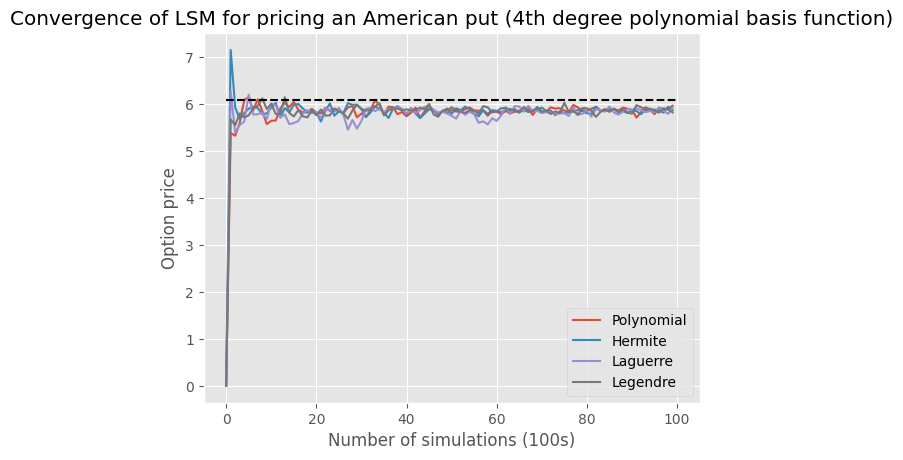

In [36]:
# Examining convergence

# Removes printing of confidence intervals
def mc_pricer_one_factor(S0, K, r, sigma, T, N, M, regression_function, featurization, deg):
    """
    Monte-Carlo pricer for options on a single asset.
    
    S0: initial asset price(s)
    K: strike price(s)
    r: risk-free rate
    sigma: volatility (-ies)
    T: time-to-maturity (years)
    N: number of subdivisions of the time interval [0,T]
    M: number of simulation paths
    regression_function: type of regression of used
    featurization: polynomial basis functions used 
    deg: degree of polynomial basis functions
    
    """
    # Simulate M stock price paths
    dt = T / N
    paths = np.empty([M, N])
    paths_anti = np.empty([M, N])
    for i in range(M):
        paths[i], paths_anti[i] = sim_path(S0, r, sigma, np.random.default_rng(), T, N)

    # Longstaff-Schwartz on both sets of paths to calculate option prices
    V = longstaff_schwartz(paths, K, r, T, N, M, regression_function, featurization, deg)
    V_anti = longstaff_schwartz(paths_anti, K, r, T, N, M, regression_function, featurization, deg)
    
    # return average
    V = 0.5 * (V + V_anti)
    V_final = np.mean(V)
    
    CI_bounds = 1.96 * (np.std(V) / np.sqrt(M)) 

    return V_final
        

prices = np.zeros(100)
prices_hermite = np.zeros(100)
prices_laguerre = np.zeros(100)
prices_legendre = np.zeros(100)

for i in range(1,100):
    M = 100 * i
    prices[i] = mc_pricer_one_factor(100, 100, 0.05, 0.2, 1, 10, M, polynomial_reg, 
                     polynomial_featurization_one_factor, 5)
    prices_hermite[i] = mc_pricer_one_factor(100, 100, 0.05, 0.2, 1, 10, M, polynomial_reg, 
                     hermite_featurization_one_factor, 5)
    prices_laguerre[i] = mc_pricer_one_factor(100, 100, 0.05, 0.2, 1, 10, M, polynomial_reg, 
                     laguerre_featurization_one_factor, 5)
    prices_legendre[i] = mc_pricer_one_factor(100, 100, 0.05, 0.2, 1, 10, M, polynomial_reg, 
                     legendre_featurization_one_factor, 5)
    
plt.plot(np.arange(100), prices)
plt.plot(np.arange(100), prices_hermite)
plt.plot(np.arange(100), prices_laguerre)
plt.plot(np.arange(100), prices_legendre)
plt.hlines(y, 0, 100, colors='black', linestyles='dashed')
plt.xlabel("Number of simulations (100s)")
plt.ylabel("Option price")
plt.title("Convergence of LSM for pricing an American put (4th degree polynomial basis function)")
plt.legend(['Polynomial', 'Hermite', 'Laguerre', 'Legendre'])


Text(0.5, 1.0, 'Convergence of squared relative errors of LSM for pricing an American put (4th degree polynomial basis function)')

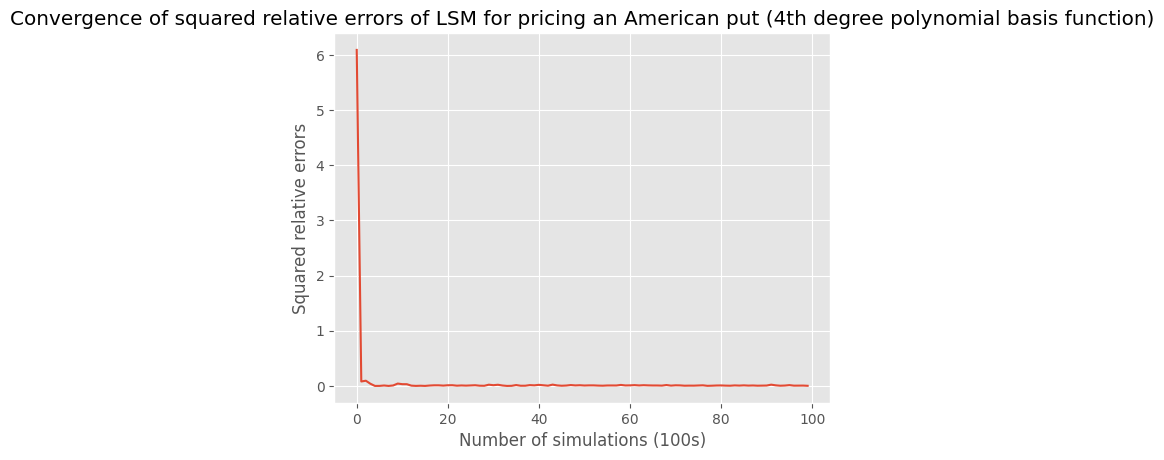

In [40]:
y = american_put_crr(100, 100, 0.05, 0.2, 1, 10000)
errors_polynomial = np.power(y - prices, 2) / y

xaxis = np.arange(100)
plt.plot(xaxis, errors_polynomial)
plt.xlabel("Number of simulations (100s)")
plt.ylabel("Squared relative errors")
plt.title("Convergence of squared relative errors of LSM for pricing an American put (4th degree polynomial basis function)")


As you can see, our estimates seem to converge rather quickly to just below the true value (as determined by a cox-ross-rubinstein tree with 15,000 steps - to be discussed more later). This is what would we expect. In their original paper, Longstaff and Schwartz note that their method will tend to underestimate the true value of the option. The choice of basis function does not seem obviously relevant for the convergence of our algorithm. This is also not too surprising. Longstaff and Schwartz note that a judicious choice of basis function becomes important for higher dimensions, but here we are working with a one-dimensional problem (the single dimension being the asset price). 


For the purposes of testing accuracy, we should make sure that our results hold for a variety of different parameter inputs to our option (e.g. different initial asset prices or different volatilities). But how do we know that our selection of parameters will ensure an accurate comparison of our models? We follow Broadie and Detemple (1996), where the authors choose a random "distribution of parameters that is a reasonable reflection of options that are of interest to academics and practitioners." Please refer to their paper (pages 1224-1225) for the distribution. The results shown are from some particular samples of parameters that I note elsewhere.  We assume no dividends for simplicity's sake. Readers are encouraged to generate their own parameter samples to confirm the accuracy of the following comparisons.  

In the following, we present the results of various combination of choices of modules for the Monte Carlo pricer for a variety of inputs. The first table includes prices and the second includes computation times. Note the latter may be different for your computer, but the relative position of times should be the same. It is a good idea to test accuracy across different basis functions, but our examination of convergence suggested that the choice of basis function was not particularly important for our one-dimensional problem. For simplicity's sake we test only across different polynomial degrees and number of subdivisions, though it is encouraged in practice to test across different basis functions and different numbers of simulations. 

We use root mean squared (RMS) relative error to measure accuracy:

$$ RMSE = \sqrt{\frac{1}{m} \sum_{i=1}^{m} e_{i}^{2}  },  $$

where $e_{i} = \frac{ C_{i}^{*} - C_{i}} {C_{i}} $ 

is the relative error of the ith simulation and $C_{i}$ denotes the true option price (as determined by a cox-ross-rubinstein binomial tree with n = 15,000 steps) and $C_{i}^{*}$ denotes the estimated option value.  


In [1]:
# Parameter selection from predetermined distributions
import numpy as np

def broadie_detemple(call, n=1):
    """
    call: bool that is True if a call and False if a put
    n (int): number of parameter selections
    """
    
    sigma = np.random.uniform(0.1, 0.6, n)
    T = np.zeros(n)
    for i in range(n):
        x = np.random.uniform(0, 1)
        if x < 0.75:
            T[i] = np.random.uniform(0.1, 1)
        else:
            T[i] = np.random.uniform(1, 5)
    K = np.ones((n)) * 100
    S0 = np.random.uniform(70, 130, n)
    
    if call:
        div = np.random.uniform(0, 0.1, n)
        r = np.zeros(n)
        for i in range(n):
            x = np.random.uniform(0, 1)
            if x < 0.8:
                r[i] = np.random.uniform(0, 0.1)
            else:
                r[i] = 0
    else:
        r = np.random.uniform(0, 0.1, n)
        div = np.zeros(n)
        for i in range(n):
            x = np.random.uniform(0, 1)
            if x < 0.8:
                div[i] = np.random.uniform(0, 0.1)
            else:
                div[i] = 0
                
    return np.array([S0, K, r, sigma, T])



In [27]:
# Comparing across degrees and number of subdivisions

def sim_path(S0, r, sigma, rng, T, N):
    """Returns two simulated paths of Geometric Brownian Motion, one based on standard normal draw Z and 
    and one based on -Z."""
    dt = T / N
    S = np.zeros(N)
    S_anti = np.zeros(N)
    drift = np.exp((r - 0.5 * np.power(sigma,2)) * dt)
    S[0] = S0 
    S_anti[0] = S0 

    for i in range(1, N):
        Z = rng.normal(0,1)
        S[i] = S[i - 1] * drift * np.exp(sigma * np.sqrt(dt) * Z)
        S_anti[i] = S_anti[i - 1] * drift /  np.exp(sigma * np.sqrt(dt) * Z)

    return S, S_anti

def mc_pricer_one_factor(S0, K, r, sigma, T, N, M, regression_function, featurization, deg):
    """
    Monte-Carlo pricer for options on a single asset. Returns the 
    average of the Monte-Carlo simulation along with a 95% confidence
    interval as a tuple of the form (option_price, left_interval,
    right_interval).
    
    S0: initial asset price(s)
    K: strike price(s)
    r: risk-free rate
    sigma: volatility (-ies)
    T: time-to-maturity (years)
    N: number of subdivisions of the time interval [0,T]
    M: number of simulation paths
    regression_function: type of regression of used
    featurization: polynomial basis functions used 
    deg: degree of polynomial basis functions
    
    """
    # Simulate M number of stock price paths
    dt = T / N
    paths = np.empty([M, N])
    paths_anti = np.empty([M, N])
    for i in range(M):
        paths[i], paths_anti[i] = sim_path(S0, r, sigma, np.random.default_rng(), T, N)

    # Longstaff-Schwartz on both sets of paths to calculate option prices
    V = longstaff_schwartz(paths, K, r, T, N, M, regression_function, featurization, deg)
    V_anti = longstaff_schwartz(paths_anti, K, r, T, N, M, regression_function, featurization, deg)
    
    # return average
    V = 0.5 * (V + V_anti)
    V_final = np.mean(V)
    
    CI_bounds = 1.96 * (np.std(V) / np.sqrt(M)) 

    return V_final



In [73]:
num_params = 25
params = broadie_detemple(False, num_params)
results = np.zeros((4, 9), dtype=np.float64)
M = 5000
N = np.array([25, 50, 75, 100])

for i in range(num_params):
    S0, K, r, sigma, T = params[:, i]
    y = american_put_crr(S0, K, r, sigma, T, 1000)
    for deg in range (2, 11):
        for j in range(N.size):
            V_est = mc_pricer_one_factor(S0, K, r, sigma, T, N[j], M, 
                                         polynomial_reg, polynomial_featurization_one_factor, deg)
            rel_error = ((V_est - y) / y)**2
            results[j, deg - 2] += rel_error

results = results / num_params

In [77]:
results

array([[0.00853701, 0.01177967, 0.01124125, 0.01356412, 0.00618932,
        0.02065307, 0.00611724, 0.00863848, 0.00653837],
       [0.01391893, 0.00820488, 0.00977154, 0.00887539, 0.02222881,
        0.00550136, 0.02624284, 0.00996544, 0.01542518],
       [0.00883602, 0.01434678, 0.01142082, 0.01670887, 0.01079611,
        0.00522357, 0.00718321, 0.01099284, 0.0061381 ],
       [0.0063886 , 0.0127555 , 0.01116779, 0.00605377, 0.01381589,
        0.03103954, 0.00846093, 0.01669977, 0.01496664]])

In [78]:
import pandas as pd

df_results = pd.DataFrame(results, columns=[f'{i}' for i in range(2,11)])
df_results.rename(index={0:'25', 1: '50', 2: '75', 3: '100'}, inplace=True)
df_results

,2,3,4,5,6,7,8,9,10
25,0.008537,0.011780,0.011241,0.013564,0.006189,0.020653,0.006117,0.008638,0.006538
50,0.013919,0.008205,0.009772,0.008875,0.022229,0.005501,0.026243,0.009965,0.015425
75,0.008836,0.014347,0.011421,0.016709,0.010796,0.005224,0.007183,0.010993,0.006138
100,0.006389,0.012756,0.011168,0.006054,0.013816,0.031040,0.008461,0.016700,0.014967


<Axes: >

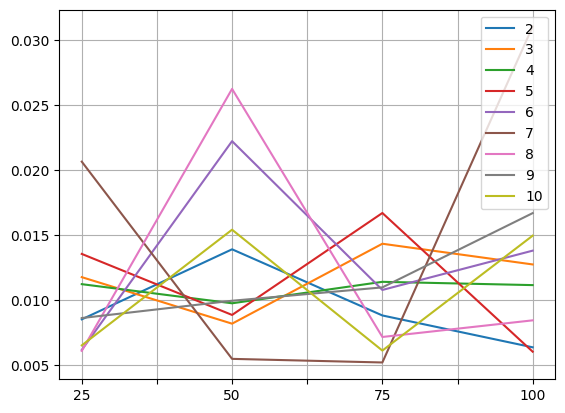

In [79]:
df_results.plot(grid=True)

<Axes: >

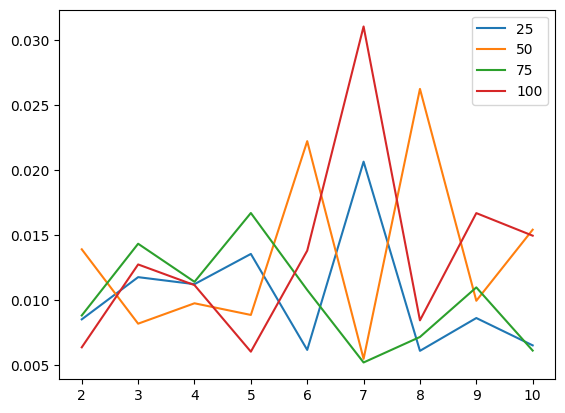

In [80]:
df_results.transpose().plot()

<Axes: >

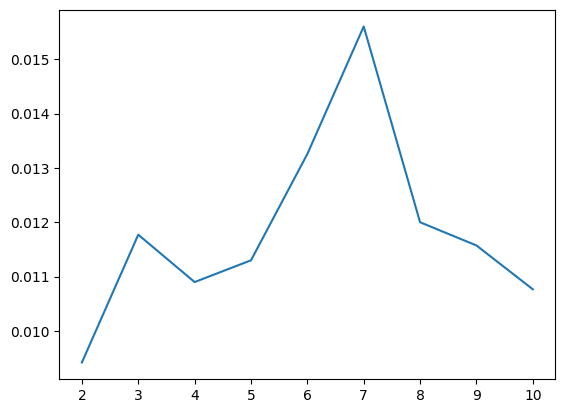

In [90]:
df_results.mean().plot()

For the one-dimensional case, it seems that higher-degree polynomial features are not necessary and are perhaps harmful to accuracy. This is not too surprising; Longstaff and Schwartz suggest that higher-degree polynomials are useful in higher-dimensional cases. Including too many polynomial features (features that will be highly correlated) for the one-dimensional case can lead to overfitting, which is the likely source of our increased errors for higher-degree polynomial featurizations. The differences in RMSE are slight and there is a drop in error with the highest degrees. In the future, we should include a large selection of random broadie-detemple parameters. 

There is one further basis for comparision: regression method. Earlier we introduced a random forest regression. This is much slower than ordinary least squares, but it may be more accurate. An examination of the predictor spaces for two-asset cases will suggest the usefulness of random forests, but we will leave that for the discussion of the multi-asset case. 

$$ Multiple \ Assets \ (WIP) $$

We mentioned earlier that Monte Carlo is important for "higher-dimensional" derivative securities, but what do we mean by this? In our Monte Carlo pricer for an American put on a single asset, we ran M simulations. In each simulation, we only kept track one one variable, the asset price. We can add more variables. For example, we could simulate several assets which are correlated in some way. If we simulate *d* assets, then our simulation will have *d* dimensions, because for each of the M simulations, we must keep track of *d* variables at each time step. For tree-based and finite difference methods, the computational cost of extra dimensions increases much quicker than it does in Monte Carlo methods. 

We might include other variables as extra dimensions. For example, we could keep track of a time-dependent, random volatility (or volatilities for multiple simulated assets) or a time-dependent, random risk-free rate. In this notebook, we will consider the multi-asset case. For a given sequence of standard normal draws, we can use this sequence to generate correlated random walks of multiple assets. We only assume that we have some covariance matrix for the assets. Each Monte Carlo simulation then generate multiple asset price paths, one for each asset being considered. 

For *d*-asset correlated GBM, we are sampling from a multivariate normal distribution with covariance matrix denote by a capital sigma. In order to generate correlated normals, we first generate *d* standard normals without reference to their correlation. We then require a matrix that will give a linear transformation of these *d* standard normals such that the resulting transformed vector, W, will satisfy 

$$E[WW^T] = \Sigma $$

This can be accomplished by taking the Cholesky decomposition of the covariance matrix. 

$$ Bibliography $$

Boyle, Phelim, Broadie, Mark and Glasserman, Paul. "Monte Carlo methods for security pricing." In *Journal of Economic Dynamics and Control* 21 (1997): 1267-1321. 

Broadie, Mark, and Detemple, Jerome "American option valuation: new bounds, approximations, and a comparison of existing methods." In *The Review of Financial Studies* 9, no. 4 (Winter, 1996): 1211-1250. 

Glasserman, Paul. *Monte Carlo Methods in Financial Engineering*. New York: Springer-Verlag, 2004. 

Jäckel, Peter. *Monte Carlo Methods in Finance*. Chichester, UK: John Wiley & Sons, 2002. 

Joshi, Mark. *More Mathematical Finance*. Melbourne: Pilot Whale Press, 2011. 

Longstaff, Francis, and Schwartz, Eduardo. "Valuing American options by simulation: a simple least-squares approach." In *The Review of Financial Studies* 14, no. 1 (Spring 2001): 113-147. 
